In [ ]:
import numpy as np
import matplotlib as mpl
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import pandas as pd
import pickle
from DSA import DSA
import torch
from scripts.ds_class import *
from scripts.time_series import *
from scripts.ra import *
#import .scripts.homeos
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def grid_search_dsa(traj_1, traj_2):
    n_delays_list = [5,10,25,50,100]
    rank_list = [5,10,25,50,75]
    ds_scores = np.zeros((len(n_delays_list), len(rank_list)))
    for i,n_delays in enumerate(n_delays_list):
        for j,rank in enumerate(rank_list):
            ds = DSA(traj_1, traj_2, n_delays=n_delays, rank=rank)
            score = ds.fit_score()
            ds_scores[i,j] = score
            print("N_delays: ", n_delays, "rank: ", rank, "DSA score: ", score)

def load_pca(m1):
    d1 = m1
    d1f = d1.reshape(-1,d1.shape[-1])
    pca = PCA(n_components=2)
    red = pca.fit_transform(d1f)
    red = red.reshape(d1.shape[0],d1.shape[1],-1)
    print(red.shape)
    print(np.cumsum(pca.explained_variance_ratio_))

    return d1,d1f,red

#motif1,d1f,red1 = load_pca(trajectories_source)

In [ ]:
# alteration to DSA to allow X and Y to have different lengths
from DSA.dmd import DMD
from DSA.kerneldmd import KernelDMD
from DSA.simdist import SimilarityTransformDist
from typing import Literal
import torch
import numpy as np
from omegaconf.listconfig import ListConfig

class DSA:
    """
    Computes the Dynamical Similarity Analysis (DSA) for two data matrices
    """
    def __init__(self,
                X,
                Y=None,
                n_delays=1,
                delay_interval=1,
                rank=None,
                rank_thresh=None,
                rank_explained_variance = None,
                lamb = 0.0,
                send_to_cpu = True,
                iters = 1500,
                score_method: Literal["angular", "euclidean","wasserstein"] = "angular",
                lr = 5e-3,
                group: Literal["GL(n)", "O(n)", "SO(n)"] = "O(n)",
                zero_pad = False,
                device = 'cpu',
                verbose = False,
                reduced_rank_reg = False,
                kernel=None,
                num_centers=0.1,
                svd_solver='arnoldi',
                wasserstein_compare: Literal['sv','eig',None] = None
            ):
        """
        Parameters
        __________

        X : np.array or torch.tensor or list of np.arrays or torch.tensors
            first data matrix/matrices
        
        Y : None or np.array or torch.tensor or list of np.arrays or torch.tensors
            second data matrix/matrices. 
            * If Y is None, X is compared to itself pairwise 
            (must be a list)
            * If Y is a single matrix, all matrices in X are compared to Y
            * If Y is a list, all matrices in X are compared to all matrices in Y
        
        DMD parameters: 

        n_delays : int or list or tuple/list: (int,int), (list,list),(list,int),(int,list)
            number of delays to use in constructing the Hankel matrix
        
        delay_interval : int or list or tuple/list: (int,int), (list,list),(list,int),(int,list)
            interval between samples taken in constructing Hankel matrix

        rank : int or list or tuple/list: (int,int), (list,list),(list,int),(int,list)
            rank of DMD matrix fit in reduced-rank regression
        
        rank_thresh : float or list or tuple/list: (float,float), (list,list),(list,float),(float,list)
            Parameter that controls the rank of V in fitting HAVOK DMD by dictating a threshold
            of singular values to use. Explicitly, the rank of V will be the number of singular
            values greater than rank_thresh. Defaults to None.
        
        rank_explained_variance : float or list or tuple: (float,float), (list,list),(list,float),(float,list)
            Parameter that controls the rank of V in fitting HAVOK DMD by indicating the percentage of
            cumulative explained variance that should be explained by the columns of V. Defaults to None.
        
        lamb : float
            L-1 regularization parameter in DMD fit
        
        send_to_cpu: bool
            If True, will send all tensors in the object back to the cpu after everything is computed.
            This is implemented to prevent gpu memory overload when computing multiple DMDs.

        NOTE: for all of these above, they can be single values or lists or tuples,
            depending on the corresponding dimensions of the data
            If at least one of X and Y are lists, then if they are a single value
                it will default to the rank of all DMD matrices. 
            If they are (int,int), then they will correspond to an individual dmd matrix
                OR to X and Y respectively across all matrices
            If it is (list,list), then each element will correspond to an individual
                dmd matrix indexed at the same position

        SimDist parameters:

        iters : int
            number of optimization iterations in Procrustes over vector fields
        
        score_method : {'angular','euclidean'}
            type of metric to compute, angular vs euclidean distance
        
        lr : float
            learning rate of the Procrustes over vector fields optimization

        group : {'SO(n)','O(n)', 'GL(n)'}
            specifies the group of matrices to optimize over

        zero_pad : bool
            whether or not to zero-pad if the dimensions are different

        device : 'cpu' or 'cuda' or int
            hardware to use in both DMD and PoVF
        
        verbose : bool
            whether or not print when sections of the analysis is completed
        
        wasserstein_compare : {'sv','eig',None}
            specifies whether to compare the singular values or eigenvalues
            if score_method is "wasserstein", or the shapes are different
        """
        self.X = X
        self.Y = Y
        if self.X is None and isinstance(self.Y,list):
            self.X, self.Y = self.Y, self.X #swap so code is easy

        self.check_method()
        if self.method == 'self-pairwise':
            self.data = [self.X]
        else:
            self.data = [self.X, self.Y]
        
        self.n_delays = self.broadcast_params(n_delays,cast=int)
        self.delay_interval = self.broadcast_params(delay_interval,cast=int)
        self.rank = self.broadcast_params(rank,cast=int)
        self.rank_thresh = self.broadcast_params(rank_thresh)
        self.rank_explained_variance = self.broadcast_params(rank_explained_variance)
        self.lamb = self.broadcast_params(lamb)
        self.send_to_cpu = send_to_cpu
        self.iters = iters
        self.score_method = score_method
        self.lr = lr
        self.device = device
        self.verbose = verbose    
        self.zero_pad = zero_pad       
        self.group = group     
        self.reduced_rank_reg = reduced_rank_reg
        self.kernel = kernel
        self.wasserstein_compare = wasserstein_compare
       
        if kernel is None:
            #get a list of all DMDs here
            self.dmds = [[DMD(Xi,
                    self.n_delays[i][j],
                    delay_interval=self.delay_interval[i][j],
                    rank=self.rank[i][j],
                    rank_thresh=self.rank_thresh[i][j], 
                    rank_explained_variance=self.rank_explained_variance[i][j],
                    reduced_rank_reg=self.reduced_rank_reg,
                    lamb=self.lamb[i][j],
                    device=self.device,
                    verbose=self.verbose,
                    send_to_cpu=self.send_to_cpu) for j,Xi in enumerate(dat)] for i,dat in enumerate(self.data)]
        else:
             #get a list of all DMDs here
            self.dmds = [[KernelDMD(Xi,
                    self.n_delays[i][j],
                    kernel=self.kernel,
                    num_centers=num_centers,
                    delay_interval=self.delay_interval[i][j],
                    rank=self.rank[i][j],
                    reduced_rank_reg=self.reduced_rank_reg,
                    lamb=self.lamb[i][j],
                    verbose=self.verbose,
                    svd_solver=svd_solver,
                    ) for j,Xi in enumerate(dat)] for i,dat in enumerate(self.data)]

        self.simdist = SimilarityTransformDist(iters,score_method,lr,device,verbose,group,wasserstein_compare)

    def check_method(self):
        '''
        helper function to identify what type of dsa we're running
        '''
        tensor_or_np = lambda x: isinstance(x,(np.ndarray,torch.Tensor))

        if isinstance(self.X,list):
            if self.Y is None:
                self.method = 'self-pairwise'
            elif isinstance(self.Y,list):
                self.method = 'bipartite-pairwise'
            elif tensor_or_np(self.Y):
                self.method = 'list-to-one'
                self.Y = [self.Y] #wrap in a list for iteration
            else:
                raise ValueError('unknown type of Y')
        elif tensor_or_np(self.X):
            self.X = [self.X]
            if self.Y is None:
                raise ValueError('only one element provided')
            elif isinstance(self.Y,list):
                self.method = 'one-to-list'
            elif tensor_or_np(self.Y):
                self.method = 'default'
                self.Y = [self.Y]
            else:
                raise ValueError('unknown type of Y')
        else:
            raise ValueError('unknown type of X')

    def broadcast_params(self,param,cast=None):
        '''
        aligns the dimensionality of the parameters with the data so it's one-to-one
        '''
        out = []
        if isinstance(param,(int,float,np.integer)) or param is None: #self.X has already been mapped to [self.X]
            out.append([param] * len(self.X))
            if self.Y is not None:
                out.append([param] * len(self.Y))
        elif isinstance(param,(tuple,list,np.ndarray,ListConfig)):
            if self.method == 'self-pairwise' and len(param) >= len(self.X):
                out = [param]
            else:
                assert len(param) <= 2 #only 2 elements max

                #if the inner terms are singly valued, we broadcast, otherwise needs to be the same dimensions
                for i,data in enumerate([self.X,self.Y]):
                    if data is None:
                        continue
                    if isinstance(param[i],(int,float)):
                        out.append([param[i]] * len(data))
                    elif isinstance(param[i],(list,np.ndarray,tuple)):
                        assert len(param[i]) >= len(data)
                        out.append(param[i][:len(data)]) 
        else:
            raise ValueError("unknown type entered for parameter")

        if cast is not None and param is not None:
            out = [[cast(x) for x in dat] for dat in out]

        return out
        
    def fit_dmds(self,
                 X=None,
                 Y=None,
                 n_delays=None,
                 delay_interval=None,
                 rank=None,
                 rank_thresh = None,
                 rank_explained_variance=None,
                 reduced_rank_reg=None,
                 lamb = None,
                 device='cpu',
                 verbose=False,
                 send_to_cpu=True
                ):
        """
        Recomputes only the DMDs with a single set of hyperparameters. This will not compare, that will need to be done with the full procedure
        """
        X = self.X if X is None else X
        Y = self.Y if Y is None else Y
        n_delays = self.n_delays if n_delays is None else n_delays
        delay_interval = self.delay_interval if delay_interval is None else delay_interval
        rank = self.rank if rank is None else rank
        lamb = self.lamb if lamb is None else lamb
        data = []
        if isinstance(X,list):
            data.append(X)
        else:
            data.append([X])
        if Y is not None:
            if isinstance(Y,list):
                data.append(Y)
            else:
                data.append([Y])
    
        dmds = [[DMD(Xi,n_delays,delay_interval,
                     rank,rank_thresh,rank_explained_variance,reduced_rank_reg,
                     lamb,device,verbose,send_to_cpu) for Xi in dat] for dat in data]
            
        for dmd_sets in dmds:
            for dmd in dmd_sets:
                dmd.fit()

        return dmds

    def fit_score(self):
        """
        Standard fitting function for both DMDs and PoVF
        
        Parameters
        __________

        Returns
        _______

        sims : np.array
            data matrix of the similarity scores between the specific sets of data     
        """
        for dmd_sets in self.dmds:
            for dmd in dmd_sets:
                dmd.fit()

        return self.score()
    
    def score(self, iters=None, lr=None, score_method=None):
        """
        Rescore DSA with precomputed dmds if you want to try again

        Parameters
        ----------
        iters : int or None
            number of optimization steps, if None then resorts to saved self.iters
        lr : float or None
            learning rate, if None then resorts to saved self.lr
        score_method : None or {'angular','euclidean'}
            overwrites the score method in the object for this application

        Returns
        -------
        score : float
            similarity score of the two precomputed DMDs
        """

        iters = self.iters if iters is None else iters
        lr = self.lr if lr is None else lr
        score_method = self.score_method if score_method is None else score_method

        ind2 = 1 - int(self.method == 'self-pairwise')

        len1 = len(self.dmds[0])
        len2 = len(self.dmds[ind2])
        self.sims = np.zeros((len1, len2))

        for i, dmd1 in enumerate(self.dmds[0]):
            for j, dmd2 in enumerate(self.dmds[ind2]):
                if self.method == 'self-pairwise' and j >= i:
                    continue

                if self.verbose:
                    print(f'computing similarity between DMDs {i} and {j}')

                self.sims[i, j] = self.simdist.fit_score(
                    dmd1.A_v, dmd2.A_v, iters, lr, score_method, zero_pad=self.zero_pad
                )

                if self.method == 'self-pairwise':
                    self.sims[j, i] = self.sims[i, j]

        if self.method == 'default':
            return self.sims[0, 0]

        return self.sims


In [ ]:
save_dir = "experiments/homeopert_ring"
df = pd.read_pickle(f"{save_dir}/ring/summary_df.pkl")

all_parameters = pickle.load(open(f"{save_dir}/ring/parameters.pkl", "rb"))
simulation_params = all_parameters['simulation_params']
ds_params = simulation_params['ds_params']
print(ds_params)
ds_params['canonical'] = True

init_conds = prepare_initial_conditions(mode=simulation_params['initial_conditions_mode'], num_points=simulation_params['number_of_target_trajectories'], margin=simulation_params['margin'], seed=simulation_params['seed'])

motifs = ['lds', 'ring', 'lc', 'bla', 'bistable', 'bibla']
motif_names = ['Linear', 'Ring', 'Limit cycle', 'BLA', 'Bistable']

all_target_trajs = []
for i, row in df.iterrows():
    interpol_value = row['interpol_value']
    trajectories_target = np.load(f"{save_dir}/trajectories_target_{row.interpol_value}.npy")
    trajectories_target = torch.tensor(trajectories_target, dtype=torch.float32).detach().numpy()
    all_target_trajs.append(trajectories_target)

all_motif_trajs = []
for j, motif in enumerate(motifs):
    simulation_params['ds_params']['ds_motif'] = motif
    if motif == 'bistable':
        analytic = False
    motif = build_ds_motif(**ds_params)
    motif_trajs = motif.compute_trajectory(torch.tensor(init_conds, dtype=torch.float32)).detach().numpy()
    all_motif_trajs.append(motif_trajs)

dsa = DSA(X =all_motif_trajs, Y=all_target_trajs, n_delays=3, rank=12, device=device, verbose=False)
score = dsa.fit_score()
np.save(f"{save_dir}/dsa_score_5motifs.npy", score)

{'ds_motif': 'ring', 'dim': 2, 'dt': 0.2, 'time_span': tensor([0., 2.]), 'analytic': True, 'vf_on_ring_enabled': True, 'alpha_init': None, 'velocity_init': None}
Loading lds
DSClass <class 'scripts.ds_class.AnalyticalLinearSystem'>
Loading ring
DSClass <class 'scripts.ds_class.AnalyticalRingAttractor'>
Loading lc
DSClass <class 'scripts.ds_class.AnalyticalLimitCycle'>
Loading bla
DSClass <class 'scripts.ds_class.AnalyticalBoundedContinuousAttractor'>
Loading bistable
DSClass <class 'scripts.ds_class.AnalyticalBistableSystem'>
Loading bibla


AssertionError: Input must have 3 dimensions.

In [4]:
save_dir = "experiments/vf_pert_ring/simple_ra"
df = pd.read_pickle(f"{save_dir}/summary_df.pkl")

all_parameters = pickle.load(open(f"{save_dir}/parameters.pkl", "rb"))
simulation_params = all_parameters['simulation_params']
init_conds = prepare_initial_conditions(mode=simulation_params['initial_conditions_mode'], num_points=simulation_params['number_of_target_trajectories'], margin=simulation_params['margin'], seed=simulation_params['seed'])

motifs = ['lds', 'ring', 'lc']
score_matrix = np.zeros((len(motifs),len(df)))

all_target_trajs = []
for i, row in df.iterrows():
    p_norm = row['p_norm']
    trajectories_target = np.load(f"{save_dir}/trajectories_target_{row.p_norm}.npy")
    trajectories_target = torch.tensor(trajectories_target, dtype=torch.float32).detach().numpy()
    all_target_trajs.append(trajectories_target)

all_motif_trajs = []
for j, motif in enumerate(motifs):
    simulation_params['ds_params']['ds_motif'] = motif
    motif = build_ds_motif(**simulation_params['ds_params'])
    motif_trajs = motif.compute_trajectory(torch.tensor(init_conds, dtype=torch.float32)).detach().numpy()
    all_motif_trajs.append(motif_trajs)


#dsa = DSA(X = all_motif_trajs, Y=all_target_trajs, n_delays=3, rank=12, device=device, verbose=False)
#score = dsa.fit_score()
#np.save(f"{save_dir}/dsa_score_lds_ring_lc.npy", score)

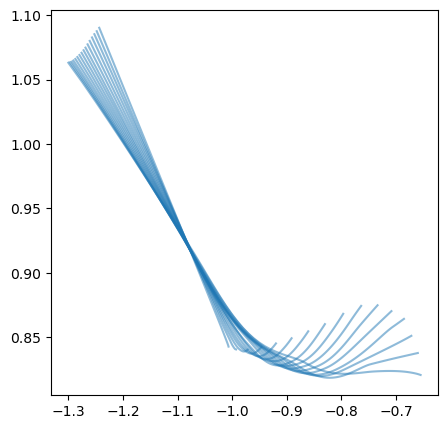

In [9]:
fig, ax = plt.subplots(figsize=(5, 5))
for i in range(len(all_target_trajs)):
    ax.plot(all_target_trajs[i][0,:,0], all_target_trajs[i][0,:,1], color='C0', alpha=0.5)

In [9]:
plt.rcParams['xtick.labelsize'] = 14  # font size
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams["font.family"] = "serif"
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42  # Use TrueType fonts (editable in Illustrator)
mpl.rcParams['ps.fonttype'] = 42   # Same for EPS
mpl.rcParams['svg.fonttype'] = 'none'  # Keep text as text in SVG

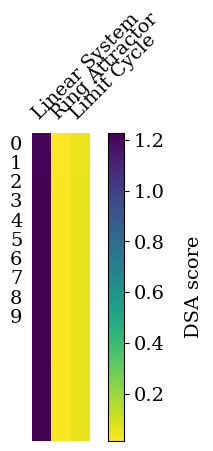

In [17]:
motif_names = ['Linear System', 'Ring Attractor', 'Limit Cycle']
system_names = ['Van Der Pol oscillator', 'Perturbed Ring Attractor', 'Stable Node']
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
im = ax.imshow(score.T, cmap='viridis_r')
cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label('DSA score', labelpad=15, fontsize=14)
N_M = len(motifs)
N_T = 10
ax.set_xticks(np.arange(N_M))
ax.set_yticks(np.arange(N_T))
ax.set_xticklabels(motif_names)
#ax.set_yticklabels(system_names)
ax.xaxis.set_ticks_position('top')
# Rotate x tick labels
plt.setp(ax.get_xticklabels(), rotation=45, ha="left", rotation_mode="anchor")

# Remove spines and ticks
ax.tick_params(top=False, bottom=False, left=False, right=False)
for spine in ax.spines.values():
    spine.set_visible(False)

#plt.savefig('figures/dsa_scores_3motifs.pdf', bbox_inches='tight')

In [39]:
save_dir = "experiments/homeopert_ring"
score = np.load(f"{save_dir}/dsa_score_lds_ring_lc.npy")

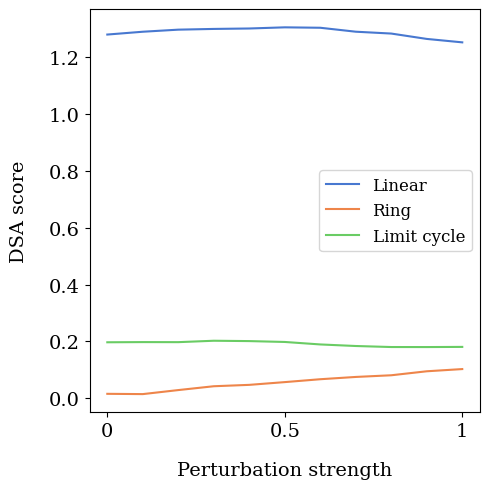

In [54]:

# Configure matplotlib and seaborn
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams["font.family"] = "serif"
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['svg.fonttype'] = 'none'
motif_names = ['Linear', 'Ring', 'Limit cycle']

colors = sns.color_palette("muted", n_colors=3)

fig, ax = plt.subplots(figsize=(5, 5))
labels = motif_names

for i in range(3):
    ax.plot(score.T[:,i], label=labels[i], color=colors[i])

ax.set_xticks([0,5,10], [0, 0.5, 1])
ax.set_ylabel('DSA score', labelpad=15, fontsize=14)
ax.set_xlabel('Perturbation strength', labelpad=15, fontsize=14)
ax.legend(fontsize=12)

plt.tight_layout()


In [ ]:
save_dir = "experiments/vf_pert_ring/simple_ra"
score = np.load(f"{save_dir}/dsa_score_lds_ring_lc.npy")

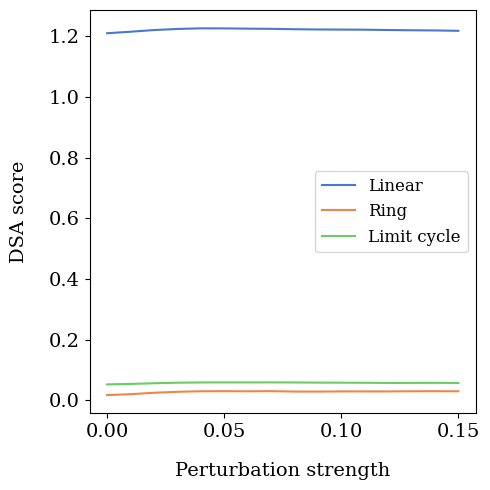

In [ ]:

# Configure matplotlib and seaborn
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams["font.family"] = "serif"
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['svg.fonttype'] = 'none'
motif_names = ['Linear', 'Ring', 'Limit cycle']

colors = sns.color_palette("muted", n_colors=3)

fig, ax = plt.subplots(figsize=(5, 5))
x = np.arange(score.shape[1]) / 100.
labels = motif_names

for i in range(3):
    ax.plot(x, score.T[:,i], label=labels[i], color=colors[i])

ax.set_ylabel('DSA score', labelpad=15, fontsize=14)
ax.set_xlabel('Perturbation strength', labelpad=15, fontsize=14)
ax.legend(fontsize=12)

plt.tight_layout()


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from DSA import DSA
import seaborn as sns
import pandas as pd 
#from netrep.metrics import LinearMetric #https://github.com/ahwillia/netrep

In [2]:
def generate_w_matrix(device, nNeurons, nBumps,length=40, wWeight=8.0, wShift=2, wScaling=True):
    """
    Generating synaptic connectivity matrix
    
    Inputs
    ------
    wWeight : positive value; sets the strength of the most inhibitory connection
    wShift : synaptic output shift for L and R populations (xi)
    wScaling : scale the raw wWeight by nNeurons and nBumps
    """
    # Calculating synaptic connectivity values #TODO change for diff connect, too small will result in multiple bumps
    # length = nNeurons / (
    #     2.28 * nBumps
    # )  # inhibition length l that produces nBumps (Eq. 47)
    length2 = int(2 * np.ceil(length))
    positions = np.arange(-length2, length2 + 1)  # Only short-range synapses between -2l and 2l
    if wScaling:  # Scale wWeight so bump shape remains the same
        strength = wWeight * nBumps / nNeurons
    else:
        strength = wWeight

    # Cosine-based connectivity function (Eq. 38)
    values = strength * (np.cos((np.pi * positions / length)) - 1) / 2
    values *= np.abs(positions) < 2 * length

    # Adding values to form unshifted row of w matrix. We form the row this way so that
    # synaptic weights are wrapped around the network in case 4 * length > nNeurons
    # (Eq. 127)
    wUnshifted = torch.zeros(nNeurons, device=device)
    for position, w in zip(positions, values):
        wUnshifted[position % nNeurons] += w

    # Form unshifted matrix of dim (nNeurons, nNeurons), then shift and form final matrix
    # of dim (2 * nNeurons, 2 * nNeurons)
    wQuadrant = torch.vstack([wUnshifted.roll(i) for i in range(nNeurons)])
    wMatrix = torch.hstack((wQuadrant.roll(-wShift, 0), wQuadrant.roll(wShift, 0)))
    wMatrix = torch.vstack((wMatrix, wMatrix))

    return wMatrix

def generate_alpha_matrix(neurons,length,alpha,device='cpu',wWeight=8,
                wShift=2,wScaling=True):
    cutoff = int((1-alpha)*length)
    wMatrix = generate_w_matrix(device,neurons+cutoff,1,length,wWeight,wShift,wScaling)
    real_w = torch.zeros((neurons*2,neurons*2),device=device)
    end = 2*neurons + cutoff
    real_w[:neurons,:neurons] = wMatrix[:neurons,:neurons] #top left
    real_w[neurons:,neurons:] = wMatrix[neurons+cutoff:end,neurons+cutoff:end] #bottom right
    real_w[:neurons,neurons:] = wMatrix[:neurons,neurons+cutoff:end] #off diagonals
    real_w[neurons:,:neurons] = wMatrix[neurons+cutoff:end,:neurons]
    return real_w

def position_quantities(nNeurons, nBumps):
    
    """
    Calculate constant quantities used repeatedly to calculate position
    """

    # Position calculation requires extraction of each bump in regions of length
    # splitLength. Neurons at the midway points between bumps may not be included
    # into a region. splitMask indicates which neural positions should not be used,
    # distributing them as evenly as possible throughout the network. For example,
    # for a network with 200 neurons (per population) and 3 bumps has regions of
    # 66 neurons with 2 neural positions unused.
    splitLength = int(np.floor(nNeurons / nBumps))
    splitRemainder = nNeurons % nBumps

    splitExtras = (nNeurons - 1) - np.arange(splitRemainder) * splitLength

    splitMask = np.ones(nNeurons, dtype=bool)
    splitMask[splitExtras] = False

    # centeredOffsets contains the positions of the first neuron in each region
    centeredOffsets = np.arange(nBumps) * splitLength
    if splitRemainder > 1:
        for i in range(splitRemainder - 1):
            centeredOffsets[-(i + 1) :] += 1

    # Converting neural positions to angles that obey the periodicity of the bumps
    # for calculating the circular mean
    angles = 2 * np.pi * nBumps / nNeurons * np.arange(nNeurons)
    cosAngles = np.cos(angles)
    sinAngles = np.sin(angles)

    return (splitMask, centeredOffsets, cosAngles, sinAngles)
def get_position(ss, nNeurons, nBumps, old, quantities):
    
    """
    Find the position of bumps

    Inputs
    ------
    ss : firing rates averaged between populations
    old : old bump positions for matching
    quantities : constants produced by position_quantities

    """

    splitLength = int(np.floor(nNeurons / nBumps))
    splitMask = quantities[0]

    # Compute the circular center of mass to calculate shift, which approximately
    # centers bumps within each extraction region. circularCenter is an average position
    # of all the bumps.
    circularCenter = (
        nNeurons
        / (2 * np.pi * nBumps)
        * circular_mean(ss, quantities[2], quantities[3])
    )
    shift = int(splitLength / 2 - circularCenter)

    
    # Shift activity so position circularCenter becomes position splitLength/2,
    # then apply mask and reshape to extract nBumps regions of length splitLength
    centeredSs = np.roll(ss, shift)[splitMask].reshape((nBumps, -1))
    centeredShifts = quantities[1] - shift

    # Compute linear center of mass for each region and undo shift to determine bump
    # positions
    centers = np.sum(
        centeredSs * np.expand_dims(np.arange(splitLength), 0), 1
    ) / np.sum(centeredSs, 1)
    centers = np.mod(centers + centeredShifts, nNeurons)

    # Reorder bumps if they have moved from one region to the next so that their
    # identities are maintained. This is done by comparing old and positions to
    # determine the ordering that minimizes their mean distance
    if nBumps > 1 and old is not None:
        match = int(
            np.round(
                np.mean(mod_offset((centers - old) / (nNeurons / nBumps), nBumps, -0.5))
            )
        )
        centers = np.roll(centers, match)

    return centers


# mod function with lower range starting at offset
def mod_offset(x, n, offset):
    return (x - offset) % n + offset


# \arctan [(\sum_i w_i \sin\theta_i) / (\sum_i w_i \cos\theta_i)]
# Then shift result to lie between 0 and 2 \pi
def circular_mean(weights, cosAngles, sinAngles):

    return np.mod(
        np.arctan2((weights * sinAngles).sum(), (weights * cosAngles).sum()), 2 * np.pi
    ).item()

class GPUSim:
    """
    A class for simulating a continuous attractor network on GPU
    
    ...
    
    Attributes
    ----------
    device (str) : name of cuda device
    nNeurons (int) : number of neurons in each L and R population (N)
    nBumps (int) : number of activity bumps in the network (M)
    dt (float) : simulation timestep
    tau (float) : time constant
    phiFunction (func) : neural transfer function
    wAttractor (tensor) : connectivity weights
    gsL (array) : synaptic inputs of left neurons
    gsR (array) : synaptic inputs of right neurons
    
    
    Methods
    -------
    evolve_network : one simulation timestep update to network 
    simulate : full simulation network
    movie : produce movie for visualization network
    
    """

    def __init__(
        self,
        device,
        nNeurons,
        nBumps,
        length = 40,
        phiFunction=torch.relu,
        wWeight=8.0,
        wShift=2,
        wAttractor=None,
        wScaling=True,
        restingMag=1.0,
        gammaMultiplier=1.0,
        gNoiseMag=None,
        fano=None,
        dt=0.5,
        tau=10.0,
        alpha = 1.0
    ):
        """
        Initializing GPU sim object
        
        Inputs
        ------
        device : cuda device name
        nNeurons : number of neurons in each population
        nBumps : number of acitivity bumps
        phiFunction : neural transfer function
        wWeight : inhibition weights
        wShift : left and right populations connectivity shifts
        wScaling : scaling connectivity to be proportional to bump number and network size
        restingMag : magnitude of resting input (A)
        gammaMultiplier : rescaling factor for drive coupling strength
        gNoiseMag : standard deviation of input noise
        fano : Fano factor for spiking noise
        dt : simulation timestep
        tau : time constant
        
        """
        self.device = device  # GPU Name, in pytorch convention
        self.nNeurons = nNeurons  # Number of neurons in each population
        self.nBumps = nBumps  # Number of activity bumps
        self.dt = dt  # timestep
        self.tau = tau  # time constant
        self.length = length
        self.phiFunction = phiFunction  # neural activation function

        if wAttractor is not None:  # Check if using predefined connectivity matrix
            self.wAttractor = wAttractor
        else:  # Otherwise creates a new connectivity matrix
            self.wAttractor = generate_alpha_matrix(
                nNeurons,
                length=self.length,
                alpha=alpha,
                wWeight=wWeight,
                wShift=wShift,
                wScaling=wScaling,
                device=device
                )

        # Quantities used for calculating bump position
        self.positionQuantities = position_quantities(nNeurons, nBumps)

        self.restingInput = restingMag * torch.ones(2 * nNeurons, device=device)
        self.gamma = (  # Coupling strength between input drive and network
            0.1
            * gammaMultiplier
            * torch.cat((-torch.ones(nNeurons), torch.ones(nNeurons))).to(device)
        )

        # Setting input noise magnitude
        self.gNoiseMag = gNoiseMag
        if self.gNoiseMag is not None and self.gNoiseMag <= 0.0:
            self.gNoiseMag = None

        # Setting Fano factor for spiking simulations
        self.fano = fano
        if self.fano is not None and self.fano <= 0.0:
            self.fano = None

    def evolve_network(self, gs, ss, deltaGs, b):
        """
        Evolve network by one timestep
        
        Inputs
        ------
        gs : synaptic inputs, concatenated across populations
        ss : firing rates, concatenated across populations
        deltaGs : updates to gs
        b : driving input
        """
        # Converting synaptic inputs to firing rates
        ss = self.phiFunction(gs)

        if self.fano is not None:  # If running spiking simulations (Eq. 128)
            ss = torch.poisson(ss * self.dt / self.fano) * self.fano / self.dt

        # Main dynamical process (Eq. 125)
        deltaGs = -gs + self.restingInput * (1.0 + self.gamma * b)
        deltaGs += torch.matmul(self.wTotal, ss)
        if self.gNoiseMag is not None:
            deltaGs += self.gNoiseMag * torch.randn_like(gs)

        gs += (self.dt / self.tau) * deltaGs

    def simulate(
        self,
        drive,
        tSim,
        pulseMag=1.0,
        pulsePosition=None,
        wNoise=None,
        saveGs=True,
        trackMotion=False,
        stuckThresh=0.01,
        tSetup=1000,
        tPulse=100,
        tStuck=2000,
        tTrack=200,
        tExtra=1000,
    ):
        """
        Simulate the continuous attractor network
        
        Inputs
        ------
        drive : input drive
        tSim : length of the time of simulation
        pulseMag : magnitude of pulse to help start network at certain positions
        pulsePosition : position at which one bump will be initialized
        wNoise (tensor) : noise in the connectivity matrix. Dim (2 * nNeurons, 2 * nNeurons)
        saveGs : to save the synaptic inputs
        trackMotion : whether to monitor bumps circling the network and getting stuck
        stuckThresh : if network position has not exceeded this value in tStuck time, network is stuck
        tSetup : time for network to initialize into a steady position
        tPulse : time of pulses to initialize network
        tStuck : time to be considered stuck
        tTrack : time range for each round of position detection
        tExtra : extra time at the end of simulation
        """

        device = self.device
        nBumps = self.nBumps
        nNeurons = self.nNeurons
        if isinstance(drive, (int, float)):  # constant drive
            self.drive = np.full(tSetup + tSim, drive)
        else:
            self.drive = drive

        if trackMotion:
            trackNow = True
        else:  # If we are not actively tracking bump motion, we get all positions at the end
            trackNow = False
            tTrack = tSim

        # Allocating memory for tracking data
        trackedGsL = torch.zeros((tTrack, nNeurons), device=device)
        trackedGsR = torch.zeros((tTrack, nNeurons), device=device)

        # Structures for accumulating gs and positions at each timestep
        self.gsL = []
        self.gsR = []
        self.positions = np.empty((0, nBumps))

        self.visited = np.zeros(nNeurons, dtype=int)  # visited positions (rounded to nearest integer)
        self.circled = False  # Check if the network has visited every neural position
        self.stuck = False  # Tracking if network is stuck in same position

        # Additional input for initializing bumps
        bumpPeriod = int(nNeurons / nBumps)  # bump distance
        pulseInds = bumpPeriod * np.arange(nBumps)  # initialize multiple bumps
        pulseInds = np.concatenate((pulseInds, nNeurons + pulseInds))  # both populations
        if pulsePosition is None:
            pulseInds += np.random.randint(bumpPeriod)
        else:
            pulseInds += int(pulsePosition % bumpPeriod)

        pulseInputs = torch.zeros(2 * nNeurons, device=device)
        pulseInputs[pulseInds] = pulseMag

        # Initializing random gs and allocating memory for ss and deltaGs
        gs = 0.1 * torch.rand(2 * nNeurons, device=device) + pulseInputs
        ss = torch.zeros_like(gs)
        deltaGs = torch.zeros_like(gs)

        currentPosition = None

        if wNoise is not None:  # If simulating with connectivity noise
            self.wTotal = self.wAttractor + wNoise
        else:
            self.wTotal = self.wAttractor

        for t in range(tSetup):  # Initialize bumps
            self.evolve_network(gs, ss, deltaGs, self.drive[t])

            if t < tPulse:  # Additional synaptic input at fixed locations
                gs += pulseInputs

        t = 0

        # Main simulation
        while t < tSim:

            # Evolve the network
            self.evolve_network(gs, ss, deltaGs, self.drive[t + tSetup])

            # Save synaptic inputs of left and right populations
            if saveGs:
                self.gsL.append(torch.clone(gs[:nNeurons]))
                self.gsR.append(torch.clone(gs[nNeurons:]))

            trackedGsL[t % tTrack] = torch.clone(gs[:nNeurons])
            trackedGsR[t % tTrack] = torch.clone(gs[nNeurons:])

            # Detecting bump positions and tracking bump motion. This is done intermittently to reduce time transferring tensors to CPU
            if (t + 1) % tTrack == 0:  # Tracking period
                trackedSs = (
                    ((self.phiFunction(trackedGsL) + self.phiFunction(trackedGsR)) / 2)
                    .cpu()
                    .numpy()
                )  # Convert synaptic inputs to activity averaged between populations

                trackedPositions = []
                for ss in trackedSs:  # For all activities tracked, find position and append
                    currentPosition = get_position(
                        ss, nNeurons, nBumps, currentPosition, self.positionQuantities
                    )
                    trackedPositions.append(currentPosition)

                trackedPositions = np.array(trackedPositions)
                self.positions = np.vstack((self.positions, trackedPositions))

                if trackNow:  # If we need to check bumps circling the network or getting stuck
                    trackedNeurons = np.unique(trackedPositions.astype(int))
                    self.visited[trackedNeurons] = 1

                    if (
                        self.visited.sum() == nNeurons
                    ):  # Check if we have visited all neural positions (rounded to integers)
                        self.circled = True
                        trackNow = False
                        t = tSim - tExtra  # Simulate tExtra more time steps
                        continue
                    if t >= tStuck and np.any(
                        np.abs(self.positions[-tStuck] - self.positions[-1])
                        < stuckThresh
                    ):  # Check if any bump has moved less than stuckThresh in the last tStuck timesteps
                        self.stuck = True
                        trackNow = False
                        t = tSim - tExtra  # Simulate tExtra more time steps
                        continue

            t += 1

        if saveGs:
            self.gsL = torch.stack(self.gsL).cpu().numpy()
            self.gsR = torch.stack(self.gsR).cpu().numpy()

In [160]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#comparison_shape = LinearMetric(center_columns=True,alpha=0,score_method='angular')
#define our transformations (sigmoid,linear scaling)
def sigmoid(x,beta):
    return 1 / (1 + torch.exp(-beta * torch.tensor(x)))
def scale(x,scale=2,beta=0.2):
    #draw random scales for each axis of the attractor, then scale the data
    #d = np.diag(np.random.choice([1,scale],size=x.shape[-1]))
    x = sigmoid(x,beta)
    d = np.diag(np.repeat(scale,x.shape[-1]))
    return x @ d

#parameters for the run here
nruns = 10 #will do multiple tests and average over
n_delays = 50
rank = 1000
diffeo = sigmoid
nneurons = 100 #here we'll keep them fixed across runs, but we varied them in the original code
burn_in = 200

if diffeo == scale:
    ts = np.arange(1,5,0.5)
    name = "scale"
    parameter = "s"
elif diffeo == sigmoid:
    ts = np.arange(0.1,4,0.5)
    name = "sigmoid"
    parameter = r"$\beta$"
print(device)

cpu


In [161]:
from torch.utils.data import random_split
import os
from scripts.utils import set_seed
from scripts.ds_class import *
from scripts.homeos import *
from scripts.plotting import *
from scripts.fit_motif import *
from scripts.time_series import *
from scripts.ra import *
set_seed(313)
exp_folder = 'experiments/'
base_save_dir = 'neuron_ring_osc'
save_dir = os.path.join(exp_folder, base_save_dir)
save_dir

'experiments/neuron_ring_osc'

In [175]:
# diffs_dmrsa = np.zeros((nruns,ts.size))
# diffs_proc = np.zeros((nruns,ts.size))
maxT = 2000
burn_in = 0
full_data_matrix = np.zeros((nruns,maxT,nneurons))
set_seed(0)
beta = ts[-1]
print(beta)
for run_j in range(3):
    print(f"on run {run_j}")
    #we'll vary the size of the bump, which changes the extrinsic dimensionality of the ring
    length = np.random.randint(int(0.55*nneurons),int(0.65*nneurons)) 
    sim = GPUSim(device, nneurons, 1,length, wScaling=False,gNoiseMag=0.01) #only 1 bump
    sim.simulate(2,maxT,wNoise=0.0) #simulate wth a drive of 2 for 3000 timesteps
    run_data = sim.gsR[burn_in:] #remove the burn-in period
    d0 = diffeo(run_data,ts[0]) #compare all to d0 (the smallest scale transform)
    d = diffeo(run_data,beta)
    #full_data_matrix[run_j,:,:] = d

#     data = []
#     for i,beta in enumerate(ts):
#         d = diffeo(run_data,beta)
#         data.append(d)
#     #     proc_score = comparison_shape.fit_score(d, d0)
#     #     diffs_proc[j,i] = proc_score
#     print("DSA")
#     dsa = DSA(d0,data,n_delays=n_delays,rank=rank,device=device,verbose=True,iters=500,lr=0.01)
#     dsa_score = dsa.fit_score()
#     diffs_dmrsa[j,:] = dsa_score

3.6
on run 0
on run 1
on run 2


C:\Users\abel_\AppData\Local\Temp\ipykernel_21080\2731655775.py:120: RuntimeWarning: invalid value encountered in divide
  centers = np.sum(


In [176]:
pca_dim = 3
pca = PCA(n_components=pca_dim)
pca.fit(d0.reshape(-1, nneurons))
full_data_matrix_pca = pca.transform(d0.reshape(-1, nneurons)).reshape(-1, 20, pca_dim)
d_pca = pca.transform(d.reshape(-1, nneurons)).reshape(-1, 20, pca_dim)
pca.explained_variance_ratio_, full_data_matrix_pca.shape

(array([0.50697047, 0.48732082, 0.00550287]), (100, 20, 3))

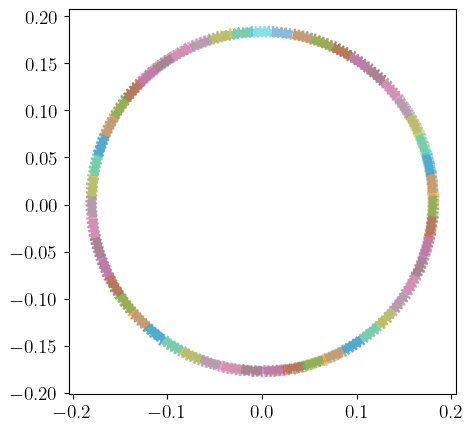

In [177]:
fig, ax = plt.subplots(figsize=(5, 5))

for i in range(full_data_matrix_pca.shape[0]):
    ax.plot(full_data_matrix_pca[i][:,0], full_data_matrix_pca[i][:,1],  alpha=0.5)

# for i in range(d_pca.shape[0]):
#     ax.plot(d_pca[i][:,0], d_pca[i][:,1],  alpha=0.5, color='C1')

Text(0.5, 0, 'sigmoid')

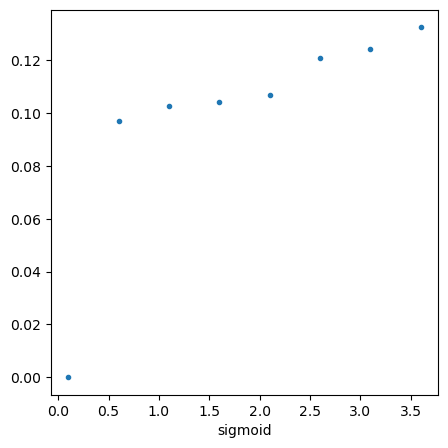

In [30]:
# fig, ax = plt.subplots(figsize=(5, 5))
# ax.plot(run_data[:,0], color='C0', alpha=0.5)

# fig, ax = plt.subplots(1, 1, figsize=(5, 5))
# ax.plot(ts, diffs_dmrsa.mean(axis=0), '.', color='C0', label='DSA', linewidth=2)
# ax.set_xlabel(name)

In [178]:
trajectories_target_full, trajectories_target, mean, std = normalize_scale_pair(torch.tensor(run_data.reshape(batch_size, -1, dim)), training_pairs=training_pairs)


10 200


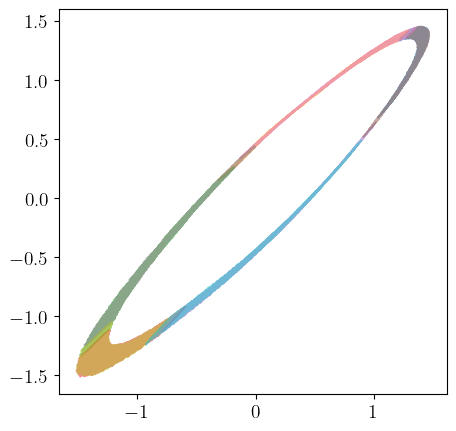

In [183]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
print(trajectories_target_full.shape[0], trajectories_target_full.shape[1])
for i in range(trajectories_target_full.shape[0]):
    ax.plot(trajectories_target_full[i][:,0], trajectories_target_full[i][:,5],  alpha=0.5)

In [184]:
homeo_type = 'node'
dim = nneurons
layer_sizes = [128]
dt = .1
batch_size = 100
T = (2000-burn_in)/batch_size*dt
time_span = torch.tensor([0.0, T])
train_ratio = 0.8
analytic = True
vf_on_ring_enabled = True
training_pairs = False
alpha_init = None
velocity_init = None
if training_pairs:
    time_span = torch.tensor([0.0, dt])
ds_motif = 'ring'
ds_params = {
    'ds_motif': ds_motif, 'dim': dim, 'dt': dt, 'time_span': time_span,
    'analytic': analytic, 'vf_on_ring_enabled': vf_on_ring_enabled,
    'alpha_init': alpha_init, 'velocity_init': velocity_init
}
homeo_params = {'homeo_type': homeo_type, 'dim': dim, 'layer_sizes': layer_sizes, 'activation': nn.ReLU, 'init_type': None}
training_params = {'lr': 0.01,'num_epochs': 100,'annealing_params': {'dynamic': False, 'initial_std': 0.0, 'final_std': 0.0},'early_stopping_patience': 1000,'batch_size': batch_size,'use_inverse_formulation': True}
trajectories_target_full, trajectories_target, mean, std = normalize_scale_pair(torch.tensor(run_data.reshape(batch_size, -1, dim)), training_pairs=training_pairs)

train_ratio = 0.8
n_train = int(train_ratio * batch_size)
n_test = batch_size - n_train
train_set, test_set = random_split(trajectories_target_full, [n_train, n_test])
trajectories_target_train = trajectories_target[train_set.indices]
trajectories_target_test = trajectories_target[test_set.indices]

# target_ra_points = get_homeo_invman(interpolated_homeo)
target_ra_points = trajectories_target[:, -1, :].reshape(-1, dim)
#target_ra_points = (target_ra_points - mean.detach().numpy()) / std.detach().numpy()

homeo = build_homeomorphism(homeo_params)
source_system_ra = build_ds_motif(**ds_params)
homeo_ds_net = Homeo_DS_Net(homeo, source_system_ra)
homeo_ds_net, losses, grad_norms = train_homeo_ds_net_batched(
    homeo_ds_net=homeo_ds_net,
    trajectories_target=trajectories_target_train,
    **training_params
)
homeo_ds_net.eval()

_, _, training_loss = test_single_homeo_ds_net(homeo_ds_net, trajectories_target_train)
_, _, test_loss = test_single_homeo_ds_net(homeo_ds_net, trajectories_target_test)
traj_src_np, traj_trans_np, _ = test_single_homeo_ds_net(homeo_ds_net, trajectories_target)

fit_ra_points = homeo_ds_net.invariant_manifold().detach().numpy()
jac_norm = jacobian_norm_over_batch(homeo_ds_net.homeo_network, trajectories_target.reshape(-1, dim))

Epoch 0, log(Loss)= -0.4280
Epoch 10, log(Loss)= -0.9742
Epoch 20, log(Loss)= -1.5443
Epoch 30, log(Loss)= -1.8559
Epoch 40, log(Loss)= -2.0113
Epoch 50, log(Loss)= -2.0783
Epoch 60, log(Loss)= -2.0989
Epoch 70, log(Loss)= -2.1100
Epoch 80, log(Loss)= -2.1145
Epoch 90, log(Loss)= -2.1170
Final log(Loss)= -2.1185, Total training time: 2006.43 sec, Avg epoch time: 20.0643 sec
Computing Jacobian norms...


KeyboardInterrupt: 

In [8]:
hdsn_path = os.path.join(save_dir, f"homeo_ds_net_{ds_motif}_na_{run_j}.pth")
save_homeo_ds_net(homeo_ds_net, hdsn_path)

Model saved to experiments/neuron_ring_osc\homeo_ds_net_ring_na_9.pth


In [198]:
homeo_type = 'node'
dim = nneurons
layer_sizes = [2]
dt = .1
batch_size = 10
T = (2000-burn_in)/batch_size*dt
time_span = torch.tensor([0.0, T])
train_ratio = 0.8
analytic = True
vf_on_ring_enabled = True
training_pairs = False
alpha_init = None
velocity_init = 1.
if training_pairs:
    time_span = torch.tensor([0.0, dt])
ds_motif = 'lc'
ds_params = {
    'ds_motif': ds_motif, 'dim': dim, 'dt': dt, 'time_span': time_span,
    'analytic': analytic, 'vf_on_ring_enabled': vf_on_ring_enabled,
    'alpha_init': alpha_init, 'velocity_init': velocity_init
}
homeo_params = {'homeo_type': homeo_type, 'dim': dim, 'layer_sizes': layer_sizes, 'activation': nn.ReLU, 'init_type': None}
training_params = {'lr': 0.01,'num_epochs': 100,'annealing_params': {'dynamic': False, 'initial_std': 0.0, 'final_std': 0.0},'early_stopping_patience': 1000,'batch_size': batch_size,'use_inverse_formulation': True}
trajectories_target_full, trajectories_target, mean, std = normalize_scale_pair(torch.tensor(run_data.reshape(batch_size, -1, dim)), training_pairs=training_pairs)

train_ratio = 0.8
n_train = int(train_ratio * batch_size)
n_test = batch_size - n_train
train_set, test_set = random_split(trajectories_target_full, [n_train, n_test])
trajectories_target_train = trajectories_target[train_set.indices]
trajectories_target_test = trajectories_target[test_set.indices]

target_ra_points = trajectories_target[:, -1, :].reshape(-1, dim)
#target_ra_points = (target_ra_points - mean.detach().numpy()) / std.detach().numpy()

homeo = build_homeomorphism(homeo_params)
source_system_lc = build_ds_motif(**ds_params)
homeo_ds_net_lc = Homeo_DS_Net(homeo, source_system_lc)
homeo_ds_net_lc, losses, grad_norms = train_homeo_ds_net_batched(homeo_ds_net=homeo_ds_net_lc,trajectories_target=trajectories_target_train,**training_params)
homeo_ds_net_lc.eval()

_, _, training_loss = test_single_homeo_ds_net(homeo_ds_net_lc, trajectories_target_train)
_, _, test_loss = test_single_homeo_ds_net(homeo_ds_net_lc, trajectories_target_test)
traj_src_np, traj_trans_np, _ = test_single_homeo_ds_net(homeo_ds_net_lc, trajectories_target)

fit_ra_points = homeo_ds_net_lc.invariant_manifold()
#jac_norm = jacobian_norm_over_batch(homeo_ds_net_lc.homeo_network, trajectories_target.reshape(-1, dim))

Epoch 0, log(Loss)= 0.0427
Epoch 10, log(Loss)= 0.0060
Epoch 20, log(Loss)= -0.0248
Epoch 30, log(Loss)= -0.0495
Epoch 40, log(Loss)= -0.0747
Epoch 50, log(Loss)= -0.1148
Epoch 60, log(Loss)= -0.2430
Epoch 70, log(Loss)= -0.4809
Epoch 80, log(Loss)= -0.5850
Epoch 90, log(Loss)= -0.6354
Final log(Loss)= -0.6876, Total training time: 1953.10 sec, Avg epoch time: 19.5310 sec


In [15]:
hdsn_path = os.path.join(save_dir, f"homeo_ds_net_{ds_motif}_vel_{run_j}.pth")
save_homeo_ds_net(homeo_ds_net_lc, hdsn_path)

Model saved to experiments/neuron_ring_osc\homeo_ds_net_lc_vel_9.pth


Testing

In [188]:
#pca 

from sklearn.decomposition import PCA
pca_dim = 3
pca = PCA(n_components=pca_dim)
pca.fit(trajectories_target.reshape(-1, dim))
traj_src_np, traj_trans_np, _ = test_single_homeo_ds_net(homeo_ds_net, trajectories_target)
trajectories_target_pca = pca.transform(trajectories_target.reshape(-1, dim)).reshape(-1, trajectories_target.shape[1], pca_dim)

traj_trans_np_pca = pca.transform(traj_trans_np.reshape(-1, dim)).reshape(-1, traj_trans_np.shape[1], pca_dim)
fit_ra_points = homeo_ds_net.invariant_manifold().detach().numpy()
fit_ra_points_pca = pca.transform(fit_ra_points.reshape(-1, dim)).reshape(-1, pca_dim)

c:\Users\abel_\anaconda3\envs\CIT_\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([20, 100])) that is different to the input size (torch.Size([200, 100])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


RuntimeError: The size of tensor a (200) must match the size of tensor b (20) at non-singleton dimension 0

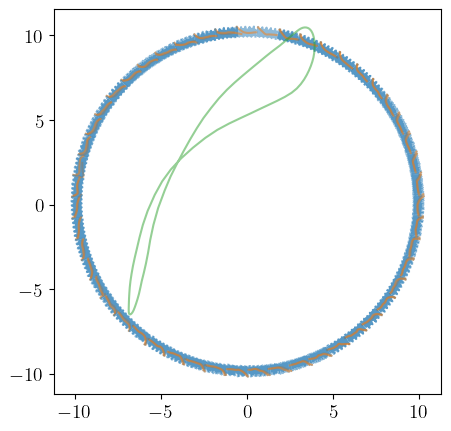

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
for i in range(trajectories_target.shape[0]):
    ax.plot(trajectories_target_pca[i][:,0], trajectories_target_pca[i][:,1], color='C0', alpha=0.5)
    ax.plot(traj_trans_np_pca[i][:,0], traj_trans_np_pca[i][:,1], color='C1', alpha=0.5)

ax.plot(fit_ra_points_pca[:,0], fit_ra_points_pca[:,1], color='C2', alpha=0.5)

In [196]:
traj_src_np_lc, traj_trans_np_lc, _ = test_single_homeo_ds_net(homeo_ds_net_lc, trajectories_target)
fit_ra_points_lc = homeo_ds_net_lc.invariant_manifold().detach().numpy()
traj_trans_np_lc_pca = pca.transform(traj_trans_np_lc.reshape(-1, dim)).reshape(-1, traj_trans_np_lc.shape[1], pca_dim)
fit_ra_points_lc_pca = pca.transform(fit_ra_points_lc.reshape(-1, dim)).reshape(-1, pca_dim)

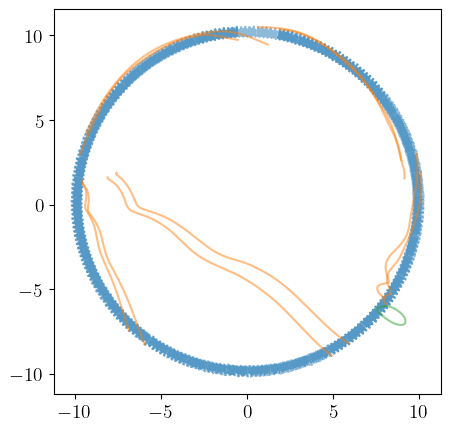

In [197]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
for i in range(trajectories_target_pca.shape[0]):
    ax.plot(trajectories_target_pca[i][:,0], trajectories_target_pca[i][:,1], color='C0', alpha=0.5)
for i in range(traj_trans_np_lc_pca.shape[0]):
    ax.plot(traj_trans_np_lc_pca[i][:,0], traj_trans_np_lc_pca[i][:,1], color='C1', alpha=0.5)

ax.plot(fit_ra_points_lc_pca[:,0], fit_ra_points_lc_pca[:,1], color='C2', alpha=0.5)